In [505]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import category_encoders as ce
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn import svm
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.ensemble import AdaBoostClassifier
import optuna
from optuna.samplers import TPESampler
from catboost import CatBoostClassifier
import sys
from lightgbm import LGBMRegressor, LGBMClassifier, Booster
from sklearn.metrics import log_loss


df = pd.read_csv('/Users/taehyun/Dropbox/Springboard/Projects/airport-codes/data/df_modeling.csv').iloc[:,2:]
df.continent.replace(np.nan, 'NA',inplace=True)
df.head()

,type,elevation_ft,continent,Longitude
0,heliport,11.0,NA,-74.933601
1,small_airport,3435.0,NA,-101.473911
2,small_airport,450.0,NA,-151.695999
3,small_airport,820.0,NA,-86.770302
4,small_airport,1100.0,NA,-97.818019


We will encode the categorical features in x with binary encoder

In [506]:
def formxy(data):    
    X = data.drop(['type'], axis =1 )
    y = data['type']
    return X, y
    
def trainvaltestsplit(x,y):
    test_size = 0.5
    X_train, X_vem, y_train, y_vem = train_test_split(x,y, train_size = 0.8, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_vem, y_vem , test_size = 0.5, random_state =42)
    return X_train, y_train, X_val, X_test, y_val, y_test

def concatvalues(x):
    counts = x.continent.value_counts()
    mask = x['continent'].isin(counts[counts < 3000].index)
    x['continent'][mask] = 'other'
    return x
    
def encode(train, val, test):    
    encoder = ce.BinaryEncoder(cols = 'continent')
    X_train_encoded = pd.DataFrame(encoder.fit_transform(train['continent']))
    X_val_encoded = pd.DataFrame(encoder.transform(val['continent']))
    X_test_encoded = pd.DataFrame(encoder.transform(test['continent']))
    
    new_df = pd.concat([X_train_encoded, train], axis = 1)
    new_df2 = pd.concat([X_val_encoded, val], axis = 1)
    new_df3 = pd.concat([X_test_encoded, test], axis = 1)
    
    new_df = new_df.drop(['continent'], axis=1)
    new_df2 = new_df2.drop(['continent'], axis=1)
    new_df3 = new_df3.drop(['continent'], axis=1)
    
    new_df = new_df.rename(columns={'continent_0': 'NA', 'continent_1':'SA','continent_2':'other','elevation_ft': 'elevation_ft','Longitude': 'longitude'})
    new_df2 = new_df2.rename(columns={'continent_0': 'NA', 'continent_1':'SA','continent_2':'other','elevation_ft': 'elevation_ft','Longitude': 'longitude'})
    new_df3 = new_df3.rename(columns={'continent_0': 'NA', 'continent_1':'SA','continent_2':'other','elevation_ft': 'elevation_ft','Longitude': 'longitude'})

    return new_df, new_df2, new_df3
    
    
def scaledata(train,val,test):
    ss = StandardScaler()
    train[['elevation_ft','longitude']]= ss.fit_transform(train[['elevation_ft','longitude']])
    val[['elevation_ft','longitude']] = ss.transform(val[['elevation_ft','longitude']])
    test[['elevation_ft','longitude']] = ss.transform(test[['elevation_ft','longitude']])


1. Limiting your Columns
    - There are way too less values for A,CA,AN. So we can make mask these as other instead of including in our encoding process.
2. make x,y
3. split data
4. encode categorical features in x
5. scale x

In [507]:
X,y = formxy(df)
print(X.shape)
print(y.shape)

(46875, 3)
(46875,)


In [508]:
X = concatvalues(X)
X.continent.value_counts()

/var/folders/z3/37b1tph56lbflqsnd5zj_8lh0000gn/T/ipykernel_15806/3985706510.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x['continent'][mask] = 'other'


NA       25017
SA        8143
other     8118
EU        5597
Name: continent, dtype: int64

In [509]:
X_train, y_train, X_val, X_test, y_val, y_test = trainvaltestsplit(X,y)

In [510]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)
print(X_test.shape)
print(y_test.shape)

(37500, 3)
(37500,)
(4687, 3)
(4687,)
(4688, 3)
(4688,)


In [511]:
X_train, X_val, X_test = encode(X_train, X_val, X_test)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(37500, 5)
(4687, 5)
(4688, 5)


In [512]:
scaledata(X_train,X_val,X_test)

# LGBM Classifier

In [513]:
model_scores = []

In [514]:
def objective(trial):
    params_lgb = {
        "random_state": 42,
        "verbosity": -1,
        "learning_rate": 0.05,
        "n_estimators": 10000,
        "objective": "multiclass",
        "metric": "multi_logloss",
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-8, 3e-5),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-8, 9e-2),
        "max_depth": trial.suggest_int("max_depth", 1, 20),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0),
        "subsample": trial.suggest_float("subsample", 0.3, 1.0),
        "subsample_freq": trial.suggest_int("subsample_freq", 1, 10),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),
        "max_bin": trial.suggest_int("max_bin", 200, 500),
    }

    model = LGBMClassifier(**params_lgb)
    model.fit(
        X_train,
        y_train,
        eval_set=[(X_train, y_train), (X_val, y_val)],
        early_stopping_rounds=100,
        verbose=False,
    )

    lgb_pred = model.predict_proba(X_val)
    log_score = log_loss(y_val, lgb_pred)
    
    return log_score

In [515]:
sampler = TPESampler(seed=42)
study = optuna.create_study(
    study_name="lgbm_parameter_opt",
    direction="minimize",
    sampler=sampler,
)
study.optimize(objective, n_trials=10)
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

model_scores.append(study.best_value)

[I 2022-09-29 03:59:50,853] A new study created in memory with name: lgbm_parameter_opt
[I 2022-09-29 03:59:54,138] Trial 0 finished with value: 0.7895332722264198 and parameters: {'reg_alpha': 1.12424581642324e-05, 'reg_lambda': 0.08556428806974939, 'max_depth': 15, 'num_leaves': 154, 'colsample_bytree': 0.4936111842654619, 'subsample': 0.40919616423534183, 'subsample_freq': 1, 'min_child_samples': 88, 'max_bin': 380}. Best is trial 0 with value: 0.7895332722264198.
[I 2022-09-29 03:59:58,158] Trial 1 finished with value: 0.6880233887925314 and parameters: {'reg_alpha': 2.1245096608103405e-05, 'reg_lambda': 0.0018526142807772773, 'max_depth': 20, 'num_leaves': 214, 'colsample_bytree': 0.5274034664069657, 'subsample': 0.42727747704497043, 'subsample_freq': 2, 'min_child_samples': 34, 'max_bin': 357}. Best is trial 1 with value: 0.6880233887925314.
[I 2022-09-29 04:00:02,413] Trial 2 finished with value: 0.6844388964415891 and parameters: {'reg_alpha': 1.2964031109077052e-05, 'reg_lambd

Best Score: 0.6811404752677401
Best trial: {'reg_alpha': 1.7560829253683595e-07, 'reg_lambda': 0.07339153040632079, 'max_depth': 15, 'num_leaves': 187, 'colsample_bytree': 0.8627622080115674, 'subsample': 0.35183125621386324, 'subsample_freq': 4, 'min_child_samples': 16, 'max_bin': 459}


# AdaBoostClassifier

In [516]:
from sklearn.ensemble import AdaBoostClassifier

def objective(trial):
    params_lgb = {
        'learning_rate' : trial.suggest_float('learning_rate', 0.01,0.1)
    }

    model = AdaBoostClassifier(**params_lgb)
    model.fit(
        X_train,
        y_train
    )

    lgb_pred = model.predict_proba(X_val)
    log_score = log_loss(y_val, lgb_pred)
    
    return log_score

In [517]:
sampler = TPESampler(seed=42)
study = optuna.create_study(
    study_name="adab_parameter_opt",
    direction="minimize",
    sampler=sampler,
)
study.optimize(objective, n_trials=10)
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

model_scores.append(study.best_value)

[I 2022-09-29 04:00:57,592] A new study created in memory with name: adab_parameter_opt
[I 2022-09-29 04:01:00,152] Trial 0 finished with value: 1.0178986343882745 and parameters: {'learning_rate': 0.04370861069626263}. Best is trial 0 with value: 1.0178986343882745.
[I 2022-09-29 04:01:02,274] Trial 1 finished with value: 1.158793309418592 and parameters: {'learning_rate': 0.09556428757689246}. Best is trial 0 with value: 1.0178986343882745.
[I 2022-09-29 04:01:04,449] Trial 2 finished with value: 1.1170715725785567 and parameters: {'learning_rate': 0.07587945476302646}. Best is trial 0 with value: 1.0178986343882745.
[I 2022-09-29 04:01:06,662] Trial 3 finished with value: 1.0852964400188714 and parameters: {'learning_rate': 0.0638792635777333}. Best is trial 0 with value: 1.0178986343882745.
[I 2022-09-29 04:01:08,868] Trial 4 finished with value: 0.938516489057175 and parameters: {'learning_rate': 0.02404167763981929}. Best is trial 4 with value: 0.938516489057175.
[I 2022-09-29 04

Best Score: 0.9050425208857866
Best trial: {'learning_rate': 0.015227525095137952}


# Cat boost

In [518]:
def class_weights():
    NA_weight = round(1 - (X.continent.value_counts()[0] / X.continent.value_counts().sum()),2)
    SA_weight = round(1 - (X.continent.value_counts()[1] / X.continent.value_counts().sum()),2)
    A_CA_AN_OC_AS_AF_weight = round(1 - (X.continent.value_counts()[2] / X.continent.value_counts().sum()),2)
    EU_weight = round(1 - (X.continent.value_counts()[3] / X.continent.value_counts().sum()),2)
    
    return NA_weight, SA_weight, A_CA_AN_OC_AS_AF_weight, EU_weight
    

In [519]:
class_weights()

(0.47, 0.83, 0.83, 0.88)

In [520]:
def ridge_objective(trial):
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.1)
    n_estimators = trial.suggest_int('n_estimators',100,500)
    max_depth = trial.suggest_int('max_depth',2,18)

    cb = CatBoostClassifier(learning_rate=learning_rate, random_state=42, loss_function = 'MultiClass', class_weights = [0.47, 0.83, 0.83, 0.94], n_estimators = n_estimators,
                           max_depth = max_depth)
    # Calculate the score with 10-folds cross validation, which returns a list of scores
    # scoring is defined as negative RMSE as it is what this Kaggle competition uses to evaluate the result
    cb.fit(X_train,y_train)
    
    lgb_pred = cb.predict_proba(X_val)
    log_score = log_loss(y_val, lgb_pred)
    # Return the mean of 10 scores
    return log_score

In [521]:
study = optuna.create_study(direction="minimize")
study.optimize(ridge_objective, n_trials=3)
print("Best Score:", study.best_value)
print("Best trial:", study.best_trial.params)

model_scores.append(study.best_value)

[I 2022-09-29 04:01:20,219] A new study created in memory with name: no-name-16231322-cb52-4dbb-a21a-f50fb00aba6c


0:	learn: 1.2689128	total: 11.6ms	remaining: 4.87s
1:	learn: 1.1780182	total: 25.4ms	remaining: 5.34s
2:	learn: 1.1071497	total: 33.6ms	remaining: 4.7s
3:	learn: 1.0504433	total: 39.2ms	remaining: 4.09s
4:	learn: 1.0002542	total: 47.2ms	remaining: 3.94s
5:	learn: 0.9580305	total: 56.9ms	remaining: 3.95s
6:	learn: 0.9232061	total: 63.3ms	remaining: 3.75s
7:	learn: 0.8939160	total: 70.4ms	remaining: 3.64s
8:	learn: 0.8696457	total: 74.1ms	remaining: 3.4s
9:	learn: 0.8445358	total: 167ms	remaining: 6.88s
10:	learn: 0.8233326	total: 177ms	remaining: 6.63s
11:	learn: 0.8033505	total: 386ms	remaining: 13.2s
12:	learn: 0.7887013	total: 390ms	remaining: 12.3s
13:	learn: 0.7721415	total: 476ms	remaining: 13.9s
14:	learn: 0.7583958	total: 497ms	remaining: 13.5s
15:	learn: 0.7452227	total: 583ms	remaining: 14.8s
16:	learn: 0.7341389	total: 792ms	remaining: 18.9s
17:	learn: 0.7257882	total: 798ms	remaining: 17.9s
18:	learn: 0.7168325	total: 1s	remaining: 21.3s
19:	learn: 0.7089060	total: 1.09s	rem

[I 2022-09-29 04:02:41,323] Trial 0 finished with value: 0.7035859372798164 and parameters: {'learning_rate': 0.07959657206170907, 'n_estimators': 422, 'max_depth': 13}. Best is trial 0 with value: 0.7035859372798164.


0:	learn: 1.2489735	total: 7.61ms	remaining: 1.39s
1:	learn: 1.1490779	total: 14.4ms	remaining: 1.31s
2:	learn: 1.0715245	total: 21.5ms	remaining: 1.3s
3:	learn: 1.0089089	total: 28.1ms	remaining: 1.26s
4:	learn: 0.9605279	total: 34.6ms	remaining: 1.24s
5:	learn: 0.9207422	total: 41.1ms	remaining: 1.22s
6:	learn: 0.8854076	total: 46.8ms	remaining: 1.18s
7:	learn: 0.8553687	total: 54.1ms	remaining: 1.19s
8:	learn: 0.8305198	total: 60.2ms	remaining: 1.17s
9:	learn: 0.8096661	total: 67.2ms	remaining: 1.17s
10:	learn: 0.7931816	total: 73.4ms	remaining: 1.15s
11:	learn: 0.7783076	total: 79.1ms	remaining: 1.13s
12:	learn: 0.7636082	total: 86.5ms	remaining: 1.14s
13:	learn: 0.7512614	total: 96ms	remaining: 1.17s
14:	learn: 0.7399833	total: 105ms	remaining: 1.18s
15:	learn: 0.7307183	total: 112ms	remaining: 1.17s
16:	learn: 0.7234197	total: 119ms	remaining: 1.17s
17:	learn: 0.7162651	total: 127ms	remaining: 1.17s
18:	learn: 0.7098585	total: 135ms	remaining: 1.17s
19:	learn: 0.7046855	total: 14

[I 2022-09-29 04:02:42,513] Trial 1 finished with value: 0.7378135851067891 and parameters: {'learning_rate': 0.09535830628768145, 'n_estimators': 184, 'max_depth': 5}. Best is trial 0 with value: 0.7035859372798164.


165:	learn: 0.6018658	total: 987ms	remaining: 107ms
166:	learn: 0.6016637	total: 993ms	remaining: 101ms
167:	learn: 0.6015698	total: 1000ms	remaining: 95.2ms
168:	learn: 0.6013042	total: 1.01s	remaining: 89.3ms
169:	learn: 0.6011678	total: 1.01s	remaining: 83.3ms
170:	learn: 0.6010150	total: 1.02s	remaining: 77.3ms
171:	learn: 0.6006628	total: 1.02s	remaining: 71.5ms
172:	learn: 0.6005285	total: 1.03s	remaining: 65.5ms
173:	learn: 0.6004073	total: 1.04s	remaining: 59.6ms
174:	learn: 0.6001842	total: 1.04s	remaining: 53.6ms
175:	learn: 0.6000969	total: 1.05s	remaining: 47.7ms
176:	learn: 0.6000457	total: 1.06s	remaining: 41.8ms
177:	learn: 0.5998202	total: 1.06s	remaining: 35.9ms
178:	learn: 0.5997329	total: 1.07s	remaining: 29.9ms
179:	learn: 0.5994871	total: 1.08s	remaining: 23.9ms
180:	learn: 0.5993703	total: 1.08s	remaining: 18ms
181:	learn: 0.5991342	total: 1.09s	remaining: 12ms
182:	learn: 0.5990513	total: 1.1s	remaining: 6ms
183:	learn: 0.5989652	total: 1.1s	remaining: 0us
0:	lea

[I 2022-09-29 04:02:45,661] Trial 2 finished with value: 0.7396641395075949 and parameters: {'learning_rate': 0.04556148294268295, 'n_estimators': 491, 'max_depth': 4}. Best is trial 0 with value: 0.7035859372798164.


490:	learn: 0.6006751	total: 2.96s	remaining: 0us
Best Score: 0.7035859372798164
Best trial: {'learning_rate': 0.07959657206170907, 'n_estimators': 422, 'max_depth': 13}


In [523]:
model_scores

[0.6811404752677401, 0.9050425208857866, 0.7035859372798164]

I used log loss so less the score, the better. Therefore, Ligh XGBM is the winner! let's use this model to train with the best parameters.

In [548]:
LGBM = LGBMClassifier(reg_alpha= 1.7560829253683595e-07, reg_lambda= 0.07339153040632079, max_depth=15, num_leaves= 187, colsample_bytree = 0.8627622080115674, subsample= 0.35183125621386324, subsample_freq =4,min_child_samples= 16, max_bin= 459)
LGBM.fit(X_train,y_train)
y_pred = LGBM.predict(X_test)
y_pred_prob = LGBM.predict_proba(X_test)

print(classification_report(y_pred,y_test))

                precision    recall  f1-score   support

      heliport       0.43      0.59      0.50       737
medium_airport       0.15      0.36      0.21       149
 seaplane_base       0.21      0.52      0.30        61
 small_airport       0.90      0.76      0.82      3741

      accuracy                           0.72      4688
     macro avg       0.42      0.56      0.46      4688
  weighted avg       0.79      0.72      0.75      4688



In [549]:
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score

def plotconfusionmatrix(y1,y2):
    cm = confusion_matrix(y1,y2)

    cm_df = pd.DataFrame(cm, index = ['heliport','medium_airport','seaplane_base','small_airport'],
                        columns = ['heliport','medium_airport','seaplane_base','small_airport'])

    plt.figure(figsize=(5,4))
    sns.heatmap(cm_df, annot=True)
    plt.title('Confusion Matrix')
    plt.ylabel('Actal Values')
    plt.xlabel('Predicted Values')
    plt.show()


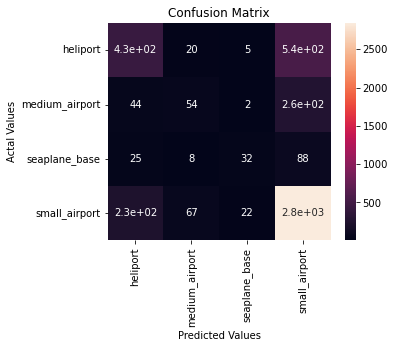

In [550]:
plotconfusionmatrix(y_test,y_pred)

micro would be better than other options for average parameter since the data is imbalanced.

In [557]:
print(f"Accuracy: {round(accuracy_score(y_test, y_pred), 2)}") 
print(f"Precision: {round(precision_score(y_test, y_pred, average = 'micro'), 2)}")
print(f"Recall: {round(recall_score(y_test, y_pred,average = 'micro'), 2)}")
print(f"F1_score: {round(f1_score(y_test, y_pred,average = 'micro'), 2)}")
print(f"log_loss: {round(log_loss(y_test, y_pred_prob),2)}")

Accuracy: 0.72
Precision: 0.72
Recall: 0.72
F1_score: 0.72
log_loss: 0.75
